In [38]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import numpy as np
from sample_grad import *
from sklearn import datasets
import time

class MNIST_small(Dataset):
    
    def __init__(self, train=True):
        digits = datasets.load_digits()
        data_num = digits['target'].shape[0]
        if train == True:
            self.data, self.target = digits['data'][:int(0.8*data_num)], digits['target'][:int(0.8*data_num)]
        else:
            self.data, self.target = digits['data'][int(0.8*data_num):], digits['target'][int(0.8*data_num):]
        
    def __len__(self):
        return self.target.shape[0]
    
    def __getitem__(self, idx):
        data = torch.from_numpy(self.data[idx]).view(1,8,8).float()
        target = torch.from_numpy(np.asarray(self.target[idx]))
        sample = {'data': data, 'target': target}
        
        return sample

#trainset = MNIST_small(train=True)
#testset = MNIST_small(train=False)

transform_MNIST = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)),
])


trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform_MNIST)
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform_MNIST)

trainloader = DataLoader(trainset, batch_size=256, shuffle=True, num_workers=0)
testloader = DataLoader(testset, batch_size=128, shuffle=False, num_workers=0)

device = torch.device('cuda:0')

### SGD

In [101]:
trainloader = DataLoader(trainset, batch_size=256, shuffle=True, num_workers=0)
testloader = DataLoader(testset, batch_size=128, shuffle=False, num_workers=0)

class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(64, 40)
        self.fc2 = nn.Linear(40, 20)
        self.fc3 = nn.Linear(20, 10)

    def forward(self, x):
        out = F.relu(self.fc1(x))
        out = F.relu(self.fc2(out))
        out = F.relu(self.fc3(out))
        return out

class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 4, 5)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(4, 8, 5)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(128, 10)

    def forward(self, x):
        y = self.conv1(x)
        y = self.relu1(y)
        y = self.pool1(y)
        y = self.conv2(y)
        y = self.relu2(y)
        y = self.pool2(y)
        y = y.view(y.shape[0], -1)
        y = self.fc1(y)
        return y        

model = LeNet().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
criterion = nn.CrossEntropyLoss()

def AccuarcyCompute(pred,label):
    pred = pred.cpu().data.numpy()
    label = label.cpu().data.numpy()
    test_np = (np.argmax(pred,1) == label)
    test_np = np.float32(test_np)
    return np.mean(test_np)
train_loss_sgd = []
test_acc_sgd = []
#for epoch in range(3):
for idx, (inputs, targets) in enumerate (trainloader):
    inputs, targets = inputs.to(device), targets.to(device)
    optimizer.zero_grad()
    outputs = model(inputs)
 
    loss = criterion(outputs,targets)
    print ('loss:{}'.format(loss.item()))
    loss.backward()
    optimizer.step()
    train_loss_sgd.append(loss.item())

    print ('testing...')
    total, correct = 0, 0
    for idx, (inputs, targets) in enumerate(testloader):    
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        correct += torch.sum(torch.argmax(outputs,1) == targets).item()
        total += inputs.shape[0]
    print (correct/total)
    test_acc_sgd.append(correct/total)
    if idx == 30:
        break

loss:2.3108510971069336
testing...
0.0872
loss:2.3222384452819824
testing...
0.0858
loss:2.307213068008423
testing...
0.0875
loss:2.2795279026031494
testing...
0.0899
loss:2.2893624305725098
testing...
0.0967
loss:2.256957530975342
testing...
0.1106
loss:2.274862289428711
testing...
0.1358
loss:2.2360527515411377
testing...
0.1652
loss:2.2438337802886963
testing...
0.1979
loss:2.221303701400757
testing...
0.233
loss:2.1821672916412354
testing...
0.2735
loss:2.174039125442505
testing...
0.3098
loss:2.1530325412750244
testing...
0.3425
loss:2.1235694885253906
testing...
0.3841
loss:2.0760481357574463
testing...
0.4248
loss:2.0730466842651367
testing...
0.464
loss:1.9727849960327148
testing...
0.5111
loss:1.9430944919586182
testing...
0.5488
loss:1.877550482749939
testing...
0.6004
loss:1.7941434383392334
testing...
0.6315
loss:1.71684992313385
testing...
0.6618
loss:1.5774327516555786
testing...
0.6786
loss:1.4497150182724
testing...
0.7063
loss:1.379602074623108
testing...
0.7255
loss:1

KeyboardInterrupt: 

[0.2736, 0.5368, 0.6795, 0.7926, 0.8307, 0.8307, 0.8307, 0.7645]

### LM

In [87]:
from torch.optim.optimizer import Optimizer
import time

class LM(Optimizer):
    '''
    Arguments:
        lr: learning rate (step size) default:1
        alpha: the hyperparameter in the regularization default:0.2
    '''
    def __init__(self, params, lr=1, alpha=0.2):
        defaults = dict(
            lr = lr,
            alpha = alpha
        )
        super(LM, self).__init__(params, defaults)

        if len(self.param_groups) != 1:
            raise ValueError ("LM doesn't support per-parameter options") 

        self._params = self.param_groups[0]['params']

    def step(self, closure=None):
        '''
        performs a single step
        in the closure: we approximate the Hessian for cross entropy loss

        '''
        assert len(self.param_groups) == 1
        group = self.param_groups[0]
        lr = group['lr']
        alpha = group['alpha']
        params = group['params']

        prev_loss, g, H = closure(sample=True)
        record_loss = prev_loss.item()
        print ('prev loss:{}'.format(prev_loss.item()))
        
        H += torch.eye(H.shape[0]).to(device)*alpha

        time_start = time.time()
        delta_w = -1 * torch.matmul(torch.inverse(H), g).detach()
        time_end = time.time()
        #print('inverting time',time_end-time_start,'s')

        offset = 0
        for p in self._params:
            numel = p.numel()
            with torch.no_grad():
                p.add_(delta_w[offset:offset + numel].view_as(p),alpha=lr)
            offset += numel

        loss = closure(sample=False)
        print ('loss:{}'.format(loss.item()))

        if loss < prev_loss:
            print ('successful iteration')
            if alpha > 1e-5:
                group['alpha'] /= 10
        else:
            print ('failed iteration')
            if alpha < 1e5:
                group['alpha'] *= 10
            # undo the step
            offset = 0
            for p in self._params:    
                numel = p.numel()
                with torch.no_grad():
                    p.sub_(delta_w[offset:offset + numel].view_as(p),alpha=lr)
                offset += numel

        return record_loss


def gather_flat_grads(params):
    '''
    return a matrix with size (batch_size, param_num)
    the flattened gradient of each sample in the batch 

    '''
    views=[]
    for p in params:
        if p.grads is None:
            view = torch.zeros_like(p.grads).view(p.grads.shape[0], -1)
        else:
            view = p.grads.view(p.grads.shape[0], -1)
        views.append(view)
    
    return torch.cat(views, 1)


In [88]:
trainloader = DataLoader(trainset, batch_size=256, shuffle=True, num_workers=0)
testloader = DataLoader(testset, batch_size=128, shuffle=False, num_workers=0)

model = LeNet().to(device)
optimizer = LM(model.parameters(),lr=0.5, alpha=1)
criterion = nn.CrossEntropyLoss()

train_loss = []
test_acc = []
#for epoch in range(3):
for idx, (inputs, targets) in enumerate(trainloader):
    inputs, targets = inputs.to(device), targets.to(device)    
    # evaluation H and g in a mini-batch
    def closure(sample=True):
        N = inputs.shape[0]
        if sample:
            time_start = time.time()
            optimizer.zero_grad()
            with save_sample_grads(model):
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                loss.backward()
                g_all = gather_flat_grads(model.parameters())
                g = g_all.sum(0)
                H = N * torch.einsum('ijk, ikl -> ijl', [torch.unsqueeze(g_all, 2), torch.unsqueeze(g_all, 1)]).sum(0)
                time_end = time.time()
                #print('sampling time',time_end-time_start,'s')
                return loss, g, H 
        else:
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            return loss
    
    record_loss = optimizer.step(closure)
    train_loss.append(record_loss)
    print ('testing...')
    total, correct = 0, 0
    for idx, (inputs, targets) in enumerate(testloader):    
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        correct += torch.sum(torch.argmax(outputs,1) == targets).item()
        total += inputs.shape[0]
    print (correct/total)
    test_acc.append(correct/total)
    if idx == 20:
        break

prev loss:2.3087401390075684
loss:2.2301197052001953
successful iteration
testing...
0.1315
prev loss:2.2388064861297607
loss:1.8129360675811768
successful iteration
testing...
0.6209
prev loss:1.8649704456329346
loss:1.3418632745742798
successful iteration
testing...
0.6945
prev loss:1.406176209449768
loss:0.9274994134902954
successful iteration
testing...
0.7748
prev loss:1.0931246280670166
loss:0.6494891047477722
successful iteration
testing...
0.8326
prev loss:0.7184281945228577
loss:0.3994014263153076
successful iteration
testing...
0.844
prev loss:0.5509270429611206
loss:282.5857238769531
failed iteration
testing...
0.844
prev loss:0.4954105019569397
loss:31.146934509277344
failed iteration
testing...
0.844
prev loss:0.6539489030838013
loss:2.006646156311035
failed iteration
testing...
0.844
prev loss:0.48103615641593933
loss:0.32787248492240906
successful iteration
testing...
0.8347
prev loss:1.1429016590118408
loss:2.2679026126861572
failed iteration
testing...
0.8347
prev loss

KeyboardInterrupt: 

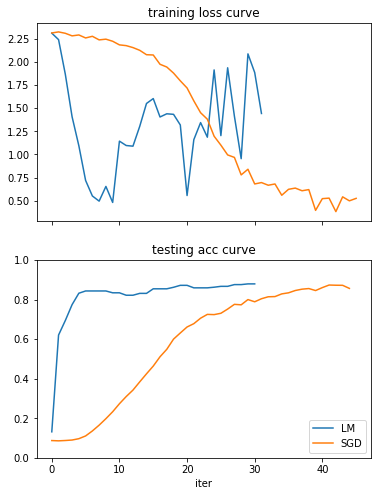

In [104]:
import matplotlib.pyplot as plt 
fig, (ax1, ax2) = plt.subplots(2,1, sharex=True, figsize=(6, 8))
ax1.plot(train_loss, label='LM')
ax1.plot(train_loss_sgd, label='SGD')
ax1.set_title('training loss curve')
ax2.plot(test_acc, label='LM')
ax2.plot(test_acc_sgd, label='SGD')
ax2.set_title('testing acc curve')
ax2.set_ylim([0, 1])
ax2.set_xlabel('iter')
plt.legend()